In [1]:
%load_ext autoreload

import os, sys
import networkx as nx

sys.path.insert(0, "../")

%autoreload 2
from mikg.kgraph import KGraph
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
#kg = KGraph()

In [3]:
#kg.load_kgraph_base("../data/", go=True, omnipath=True, opentargets=True, reactome=True, STRING=True)

HMS:0:00:10.841079 626,136 annotations READ: ../data/goa_human.gaf 
../data/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


/usr/local/hdd3/mikg/scripts/../mikg/load_utils.py:204: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  opd  = pd.read_csv(omnipathDB, sep="\t")
/usr/local/hdd3/mikg/scripts/../mikg/load_utils.py:387: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  ot_disease = pd.read_csv("../data/opentargets_disease_associations.tsv", sep="\t")
/usr/local/hdd3/mikg/scripts/../mikg/load_utils.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["score"] = subdf[use_evidences].max(axis=1)/1000


PGM3 UAP1 {'fusion': 0, 'coexpression': 77, 'experiments': 272, 'database': 900, 'textmining': 720, 'score': 0.9}
PGM3 GNPNAT1 {'fusion': 0, 'coexpression': 0, 'experiments': 0, 'database': 900, 'textmining': 700, 'score': 0.9}
PGM3 UAP1L1 {'fusion': 0, 'coexpression': 0, 'experiments': 0, 'database': 900, 'textmining': 459, 'score': 0.9}
PGM3 GLO1 {'fusion': 0, 'coexpression': 96, 'experiments': 272, 'database': 0, 'textmining': 729, 'score': 0.729}
PGM3 PGM2 {'fusion': 0, 'coexpression': 0, 'experiments': 0, 'database': 0, 'textmining': 720, 'score': 0.72}
PGM3 NAGK {'fusion': 0, 'coexpression': 0, 'experiments': 0, 'database': 900, 'textmining': 561, 'score': 0.9}
PGM3 ADI1 {'fusion': 708, 'coexpression': 42, 'experiments': 0, 'database': 0, 'textmining': 0, 'score': 0.708}
PGM3 PGM5 {'fusion': 0, 'coexpression': 0, 'experiments': 272, 'database': 0, 'textmining': 720, 'score': 0.72}
PGM3 PGM1 {'fusion': 0, 'coexpression': 0, 'experiments': 272, 'database': 0, 'textmining': 719, 'sc

In [4]:
#kg.print_kg_info()

In [5]:
#print(kg.kg)

In [6]:
#kg.save_kgraph("../data/initial_base_graph.out")

In [7]:
kg = KGraph()
kg.load_kgraph("../data/initial_base_graph.out")

In [73]:
exprDF = pd.read_csv("../seq_data/expression_mean_df.tsv", sep="\t")
cmDF = exprDF[exprDF.group == "Cardiomyocyte"]
cmDF

,group,gene,min,percentile_25,median,percentile_75,max,mean,anum,num,sd
22891,Cardiomyocyte,A1BG,0.218642,0.439190,0.607427,0.831411,2.456248,0.709995,351,351,0.395967
22892,Cardiomyocyte,A1BG-AS1,0.214143,0.456117,0.643483,0.936906,3.038826,0.806031,461,461,0.518502
22893,Cardiomyocyte,A1CF,0.208636,0.422485,0.557386,0.773439,3.025672,0.637636,706,706,0.321588
22894,Cardiomyocyte,A2M,0.181245,0.651118,0.944811,1.398837,3.792171,1.075190,32973,32973,0.547520
22895,Cardiomyocyte,A2M-AS1,0.185317,0.412732,0.539294,0.709554,2.699968,0.602207,3160,3160,0.286947
...,...,...,...,...,...,...,...,...,...,...,...
50958,Cardiomyocyte,ZXDC,0.185317,0.610198,0.829333,1.097115,3.521134,0.891553,35191,35191,0.378761
50959,Cardiomyocyte,ZYG11A,0.224826,0.414667,0.540848,0.712375,2.653949,0.637458,303,303,0.367307
50960,Cardiomyocyte,ZYG11B,0.187795,0.600248,0.812252,1.080384,3.494183,0.880513,33025,33025,0.386580
50961,Cardiomyocyte,ZYX,0.193169,0.445595,0.595571,0.835346,3.001737,0.705213,5338,5338,0.395080


In [9]:
fibDF = exprDF[exprDF.group == "Fibroblast"]
fibDF

,group,gene,min,percentile_25,median,percentile_75,max,mean,anum,num,sd
102873,Fibroblast,A1BG,0.501998,1.235752,1.491982,1.768195,3.631375,1.531841,424,424,0.470582
102874,Fibroblast,A1BG-AS1,0.364096,1.273964,1.557159,1.973099,3.494957,1.646681,740,740,0.546756
102875,Fibroblast,A1CF,0.936434,1.459199,1.669136,1.904395,2.955688,1.831157,26,26,0.580027
102876,Fibroblast,A2M,0.247064,1.381439,1.648303,1.966196,3.730105,1.697126,7728,7728,0.459571
102877,Fibroblast,A2M-AS1,0.505575,1.179612,1.453647,1.743054,2.720268,1.469821,283,283,0.438858
...,...,...,...,...,...,...,...,...,...,...,...
130942,Fibroblast,ZXDC,0.387950,1.322788,1.577880,1.881845,3.752063,1.619841,8704,8704,0.436627
130943,Fibroblast,ZYG11A,0.500970,1.192219,1.493319,1.868409,3.407745,1.553399,243,243,0.492998
130944,Fibroblast,ZYG11B,0.361290,1.331387,1.584627,1.906673,3.565702,1.633891,8709,8709,0.446266
130945,Fibroblast,ZYX,0.364096,1.292344,1.547185,1.865861,3.436410,1.594237,3505,3505,0.446001


In [75]:
exprDFs = {}

for group in exprDF.group.unique():
    exprDFs[group] = exprDF[exprDF.group == group].copy()

print([x for x in exprDFs])

['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'vSMCs']


In [10]:
kg.add_gene_expression(cmDF)

28072
Found Genes 22753


In [11]:
kg.get_node_data("CCL2")

{'type': 'gene',
 'score': 0,
 'expression': {'mean': 0.7961505602787607,
  'perc_expr': 1.0,
  'median': 0.6903093253438801}}

In [12]:
kg.get_node_data("EFO:0004775")

{'type': 'disease',
 'name': 'toxic epidermal necrolysis',
 'source': 'opentargets'}

In [13]:
kg.get_node_types()

Counter({'gene': 51578, 'geneset': 49332, 'disease': 12701, 'drug': 3212})

In [14]:
kg.get_edge_types()

Counter({'activates': 113800,
         'relevant_in': 203769,
         'interacts': 2856008,
         'part_of': 200831,
         'represses': 8381,
         'affects': 35862,
         'targeted_by': 8268})

In [15]:
kg.get_edge_between_type()

Counter({('gene', 'geneset'): 412777,
         ('gene', 'gene'): 362249,
         ('geneset', 'geneset'): 74934,
         ('geneset', 'gene'): 4072,
         ('disease', 'gene'): 2528757,
         ('drug', 'disease'): 35826,
         ('drug', 'gene'): 8268,
         ('drug', 'geneset'): 36})

In [16]:
def scoring_represses(x, y):
    return x - y

def scoring_activates(x, y):
    return x*y

def scoring_interacts(x,y):
    return x*y

def scoring_null(x,y):
    return 0

scoring_gene_gene_expression = {"represses": scoring_represses, "activates": scoring_activates, "interacts": scoring_interacts, "-": scoring_null}

def gene_geneset(kg, node, edges):
    
    allExpr = list()
    for edge in edges:
        
        otherEnd = edge[0] if node==edge[1] else edge[1]
        otherExpr = kg.nodes[otherEnd].get("expression", {}).get("mean", 0)
        
        allExpr.append(otherExpr)
    
    return np.mean(allExpr)
        
        

def geneset_geneset(kg, node, edges):
    
    allExpr = list()
    for edge in edges:
        
        otherEnd = edge[0] if node==edge[1] else edge[1]
        otherExpr = kg.nodes[otherEnd].get("score", 0)
        
        allExpr.append(otherExpr)
    
    return np.mean(allExpr)


def scoring_represses(x, y):
    return x - y

def scoring_activates(x, y):
    return x*y

def scoring_interacts(x,y):
    return x*y

def scoring_null(x,y):
    return 0

scoring_interactions = {"relevant_in": scoring_interacts,
                        "activates": scoring_activates,
                        "part_of": scoring_interacts,
                        "represses": scoring_represses,
                        "interacts": scoring_interacts,
                        "targeted_by": scoring_interacts,
                        "affects": scoring_interacts,
                        "-": scoring_null
                        }

def get_score(x):
    if x.get("type", "-") == "gene":
        return x.get("expression", {}).get("mean", 0)
    else:
        return x.get("score", 0)

In [17]:
kg.score_gene_gene_edges(scoring_gene_gene_expression)

kg.score_nodes(ntype="geneset", consider_edge_type=[("gene", "geneset")], scoring_function=gene_geneset)
kg.score_nodes(ntype="disease", consider_edge_type=[("disease", "gene")], scoring_function=gene_geneset)
kg.score_nodes(ntype="drug", consider_edge_type=[("drug", "gene")], scoring_function=gene_geneset)

kg.score_nodes(ntype="geneset", consider_edge_type=[("geneset", "geneset")], scoring_function=geneset_geneset)
kg.score_nodes(ntype="drug", consider_edge_type=[("drug", "disease")], scoring_function=geneset_geneset)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [76]:
exprKGs = {}

for group in exprDFs:
    
    print(group)
    
    gKG = KGraph()
    
    gKG.load_kgraph("../data/initial_base_graph.out")

    gKG.add_gene_expression(exprDFs[group])

    gKG.score_gene_gene_edges(scoring_gene_gene_expression)

    gKG.score_nodes(ntype="geneset", consider_edge_type=[("gene", "geneset")], scoring_function=gene_geneset)
    gKG.score_nodes(ntype="disease", consider_edge_type=[("disease", "gene")], scoring_function=gene_geneset)
    gKG.score_nodes(ntype="drug", consider_edge_type=[("drug", "gene")], scoring_function=gene_geneset)

    gKG.score_nodes(ntype="geneset", consider_edge_type=[("geneset", "geneset")], scoring_function=geneset_geneset)
    gKG.score_nodes(ntype="drug", consider_edge_type=[("drug", "disease")], scoring_function=geneset_geneset)
        
    exprKGs[group] = gKG

22891
Found Genes 19560


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


28072
Found Genes 22753
24070
Found Genes 20461
27840
Found Genes 22680
28074
Found Genes 22822
25525
Found Genes 21392
20817
Found Genes 18299
27246
Found Genes 22374
24790
Found Genes 20837
26333
Found Genes 21782
24144
Found Genes 20401


In [18]:
fibKG = KGraph()
fibKG.load_kgraph("../data/initial_base_graph.out")

fibKG.score_gene_gene_edges(scoring_gene_gene_expression)

fibKG.score_nodes(ntype="geneset", consider_edge_type=[("gene", "geneset")], scoring_function=gene_geneset)
fibKG.score_nodes(ntype="disease", consider_edge_type=[("disease", "gene")], scoring_function=gene_geneset)
fibKG.score_nodes(ntype="drug", consider_edge_type=[("drug", "gene")], scoring_function=gene_geneset)

fibKG.score_nodes(ntype="geneset", consider_edge_type=[("geneset", "geneset")], scoring_function=geneset_geneset)
fibKG.score_nodes(ntype="drug", consider_edge_type=[("drug", "disease")], scoring_function=geneset_geneset)

In [19]:
for edge in kg.get_node_edges("CCL2", in_types=["gene"], out_types=["gene"]):
    
    inExpr = kg.get_node_data(edge[0]).get("expression", {}).get("mean", 0)
    outExpr = kg.get_node_data(edge[1]).get("expression", {}).get("mean", 0)
    edgeType = kg.kg.edges[edge].get("type", "-")
    
    print(edge, edgeType, kg.kg.edges[edge]["score"])

('NFE2L2', 'CCL2') represses 0.0951349990717979
('CCL13', 'CCL2') interacts 0.6625857304149431
('JUN', 'CCL2') interacts 0.678076627194631
('FOSL1', 'CCL2') activates 0.6385272061656778
('LIF', 'CCL2') interacts 0.9927254232835401
('TNF', 'CCL2') interacts 0.7117152499574244
('TNFSF11', 'CCL2') activates 0.4971813210978469
('CSF2', 'CCL2') interacts 0.0
('CSF1', 'CCL2') interacts 0.5629802912872744
('JAK2', 'CCL2') activates 0.7929084270651282
('OLR1', 'CCL2') activates 0.6767790033398968
('FOS', 'CCL2') interacts 0.7147633967622257
('HMOX1', 'CCL2') represses 0.3253752315000341
('CDK9', 'CCL2') activates 0.5590232420261081
('IL18', 'CCL2') interacts 0.5347951866341579
('IL32', 'CCL2') activates 0.6302132415731214
('ESR2', 'CCL2') represses -0.020434977340974325
('OSM', 'CCL2') activates 0.6184311733146713
('IL6', 'CCL2') interacts 0.8415316531974776
('SAA1', 'CCL2') activates 0.6509382189399009
('FPR1', 'CCL2') activates 0.6219689539789496
('FADD', 'CCL2') activates 0.4808629802787559

In [20]:
kg.score_edges(get_score, "type", scoring_interactions, in_types=None, out_types=None, ignore_edge_types=[("gene", "gene")])

In [21]:
for edge in kg.get_node_edges("CCL2"):

    edgeType = kg.kg.edges[edge].get("type", "-")
    
    print(edge, edgeType, kg.kg.edges[edge]["score"])

('NFE2L2', 'CCL2') represses 0.0951349990717979
('CCL13', 'CCL2') interacts 0.6625857304149431
('JUN', 'CCL2') interacts 0.678076627194631
('FOSL1', 'CCL2') activates 0.6385272061656778
('LIF', 'CCL2') interacts 0.9927254232835401
('TNF', 'CCL2') interacts 0.7117152499574244
('TNFSF11', 'CCL2') activates 0.4971813210978469
('CSF2', 'CCL2') interacts 0.0
('CSF1', 'CCL2') interacts 0.5629802912872744
('JAK2', 'CCL2') activates 0.7929084270651282
('OLR1', 'CCL2') activates 0.6767790033398968
('FOS', 'CCL2') interacts 0.7147633967622257
('HMOX1', 'CCL2') represses 0.3253752315000341
('CDK9', 'CCL2') activates 0.5590232420261081
('IL18', 'CCL2') interacts 0.5347951866341579
('IL32', 'CCL2') activates 0.6302132415731214
('ESR2', 'CCL2') represses -0.020434977340974325
('OSM', 'CCL2') activates 0.6184311733146713
('IL6', 'CCL2') interacts 0.8415316531974776
('SAA1', 'CCL2') activates 0.6509382189399009
('FPR1', 'CCL2') activates 0.6219689539789496
('FADD', 'CCL2') activates 0.4808629802787559

In [22]:
kg.kg.nodes["GO:0007568"]

{'id': 'GO:0007568',
 'name': 'aging',
 'type': 'geneset',
 'ns': 'biological_process',
 'score': 0.5745062010148578,
 'source': 'GeneOntology'}

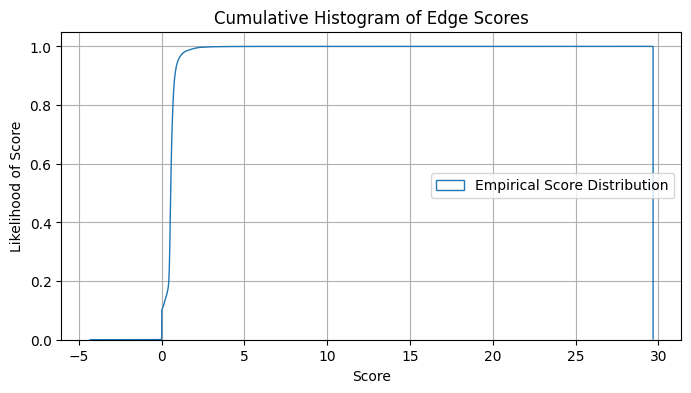

In [23]:
kg.plot_score_histogram()

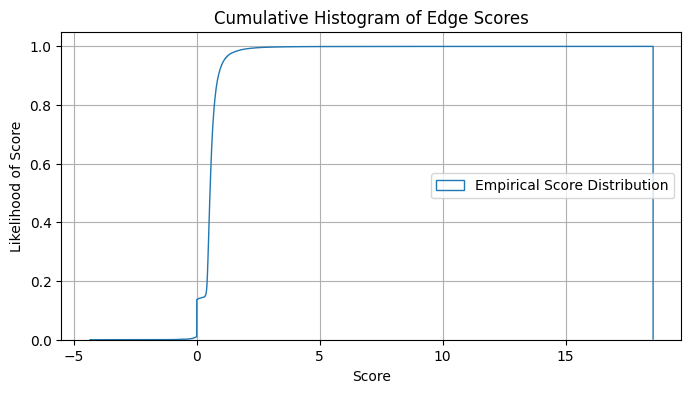

In [24]:
kg.plot_score_histogram(edge_types=[("gene", "gene")])

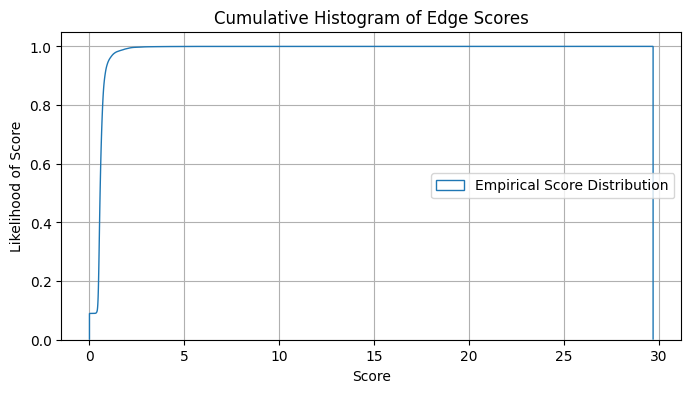

In [25]:
kg.plot_score_histogram(edge_types=[("disease", "gene")])

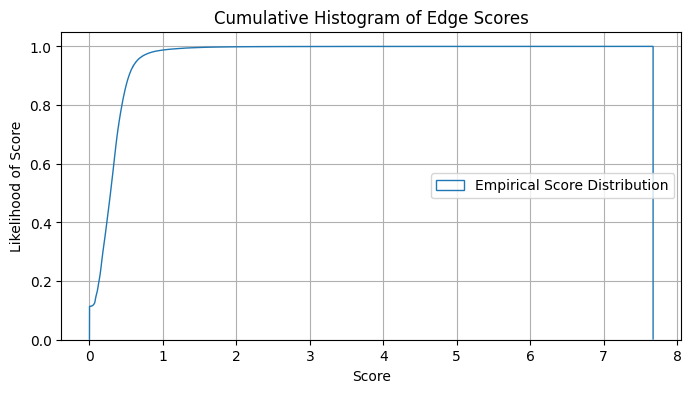

In [26]:
kg.plot_score_histogram(edge_types=[("gene", "geneset")])

['gene -> geneset', 'gene -> gene', 'geneset -> geneset', 'geneset -> gene', 'disease -> gene', 'drug -> disease', 'drug -> gene', 'drug -> geneset']
             class  value
0  gene -> geneset    0.0
1  gene -> geneset    0.0
2  gene -> geneset    0.0
3  gene -> geneset    0.0
4  gene -> geneset    0.0


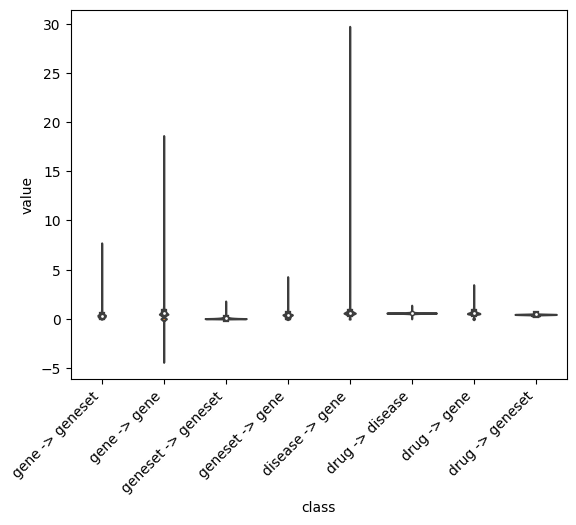

In [27]:
kg.plot_score_violin(per_edge_type=True)

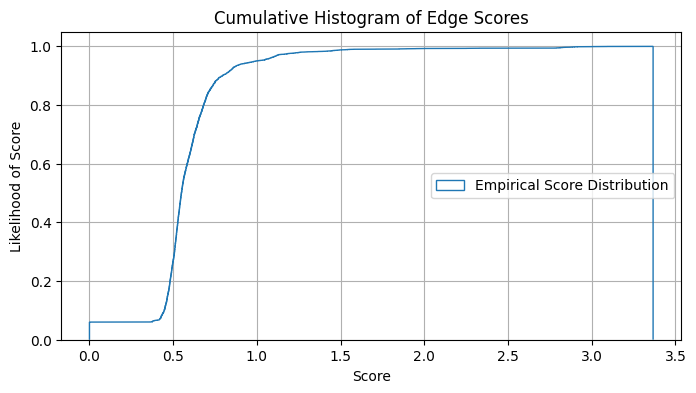

In [28]:
kg.plot_score_histogram(edge_types=[("drug", "gene")])

In [29]:
print(kg.kg)

DiGraph with 116823 nodes and 3426919 edges


In [30]:
len([x for x in kg.kg.edges if kg.kg.edges[x].get("score", 0) > 0.5])

2137509

In [31]:
sub_kg = kg.kg.edge_subgraph([x for x in kg.kg.edges if kg.kg.edges[x].get("score", 0) > 3.0]).copy()
sub_kg_ud = sub_kg.to_undirected()
print(sub_kg)

DiGraph with 2256 nodes and 4717 edges


In [32]:
import community
from collections import defaultdict

In [84]:
partition = community.best_partition(sub_kg_ud, resolution=5, random_state=42)

In [85]:
rev_partition = defaultdict(set)
for x in partition:
    rev_partition[partition[x]].add(x)

In [88]:
for x in rev_partition:
    if len(rev_partition[x]) > 10:
        print(x, len(rev_partition[x]), "PDK4" in rev_partition[x])

1 242 False
2 271 False
17 43 False
4 49 True
5 142 False
6 68 False
7 45 False
8 215 False
9 120 False
10 33 False
11 204 False
12 146 False
14 32 False
15 115 False
19 37 False
20 57 False
23 23 False
24 21 False
55 30 False
29 20 False
76 18 False
66 30 False
81 21 False
43 30 False
60 22 False


In [45]:
def plot_graph(G, close=True, pos=None):   

    #pos = nx.kamada_kawai_layout(G, pos=nx.spring_layout(G, k=0.15, iterations=20))  # For better example looking
    if pos is None:
        pos = nx.spring_layout(G, k=0.15, iterations=10)
    nx.draw_networkx_nodes(G, pos, node_size=100)
    posnodes = {}
    for x in pos:
        posnodes[x] = list(pos[x])
        posnodes[x][1] += 0.02
        
    nodelabels = {}
    for x in G.nodes:
        
        if "name" in G.nodes[x]:
            nodelabels[x] = "{}\n({})".format(G.nodes[x].get("name", x), x)
        else:
            nodelabels[x] = x
        
    nx.draw_networkx_labels(G, posnodes, labels=nodelabels)
    nx.draw_networkx_edges(G, pos, width=2, edge_cmap = plt.cm.Reds, edge_color=[G.edges[e].get("score", 0) for e in G.edges])
    if close:
        plt.show()
        plt.close()
        
    return pos

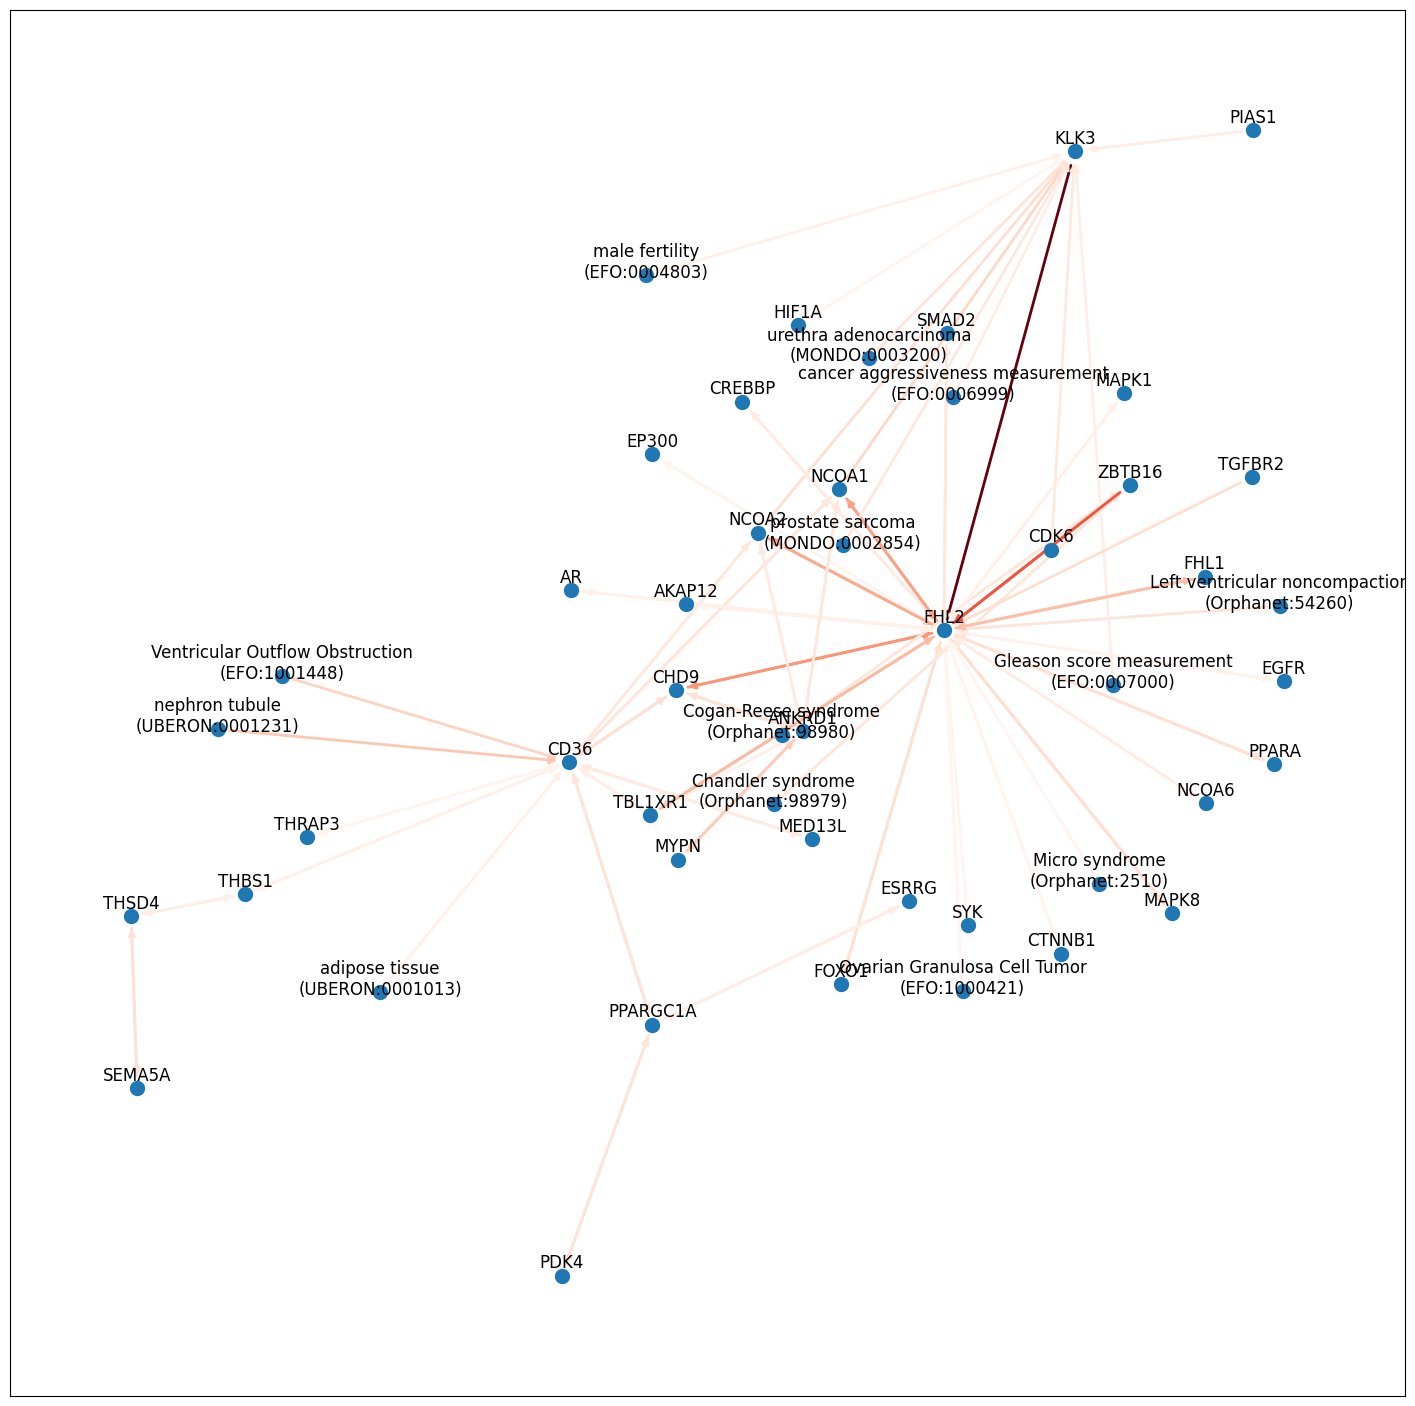

In [89]:
matplotlib.rcParams['figure.figsize'] = [18, 18]

pos=plot_graph(sub_kg.subgraph(rev_partition[4]))

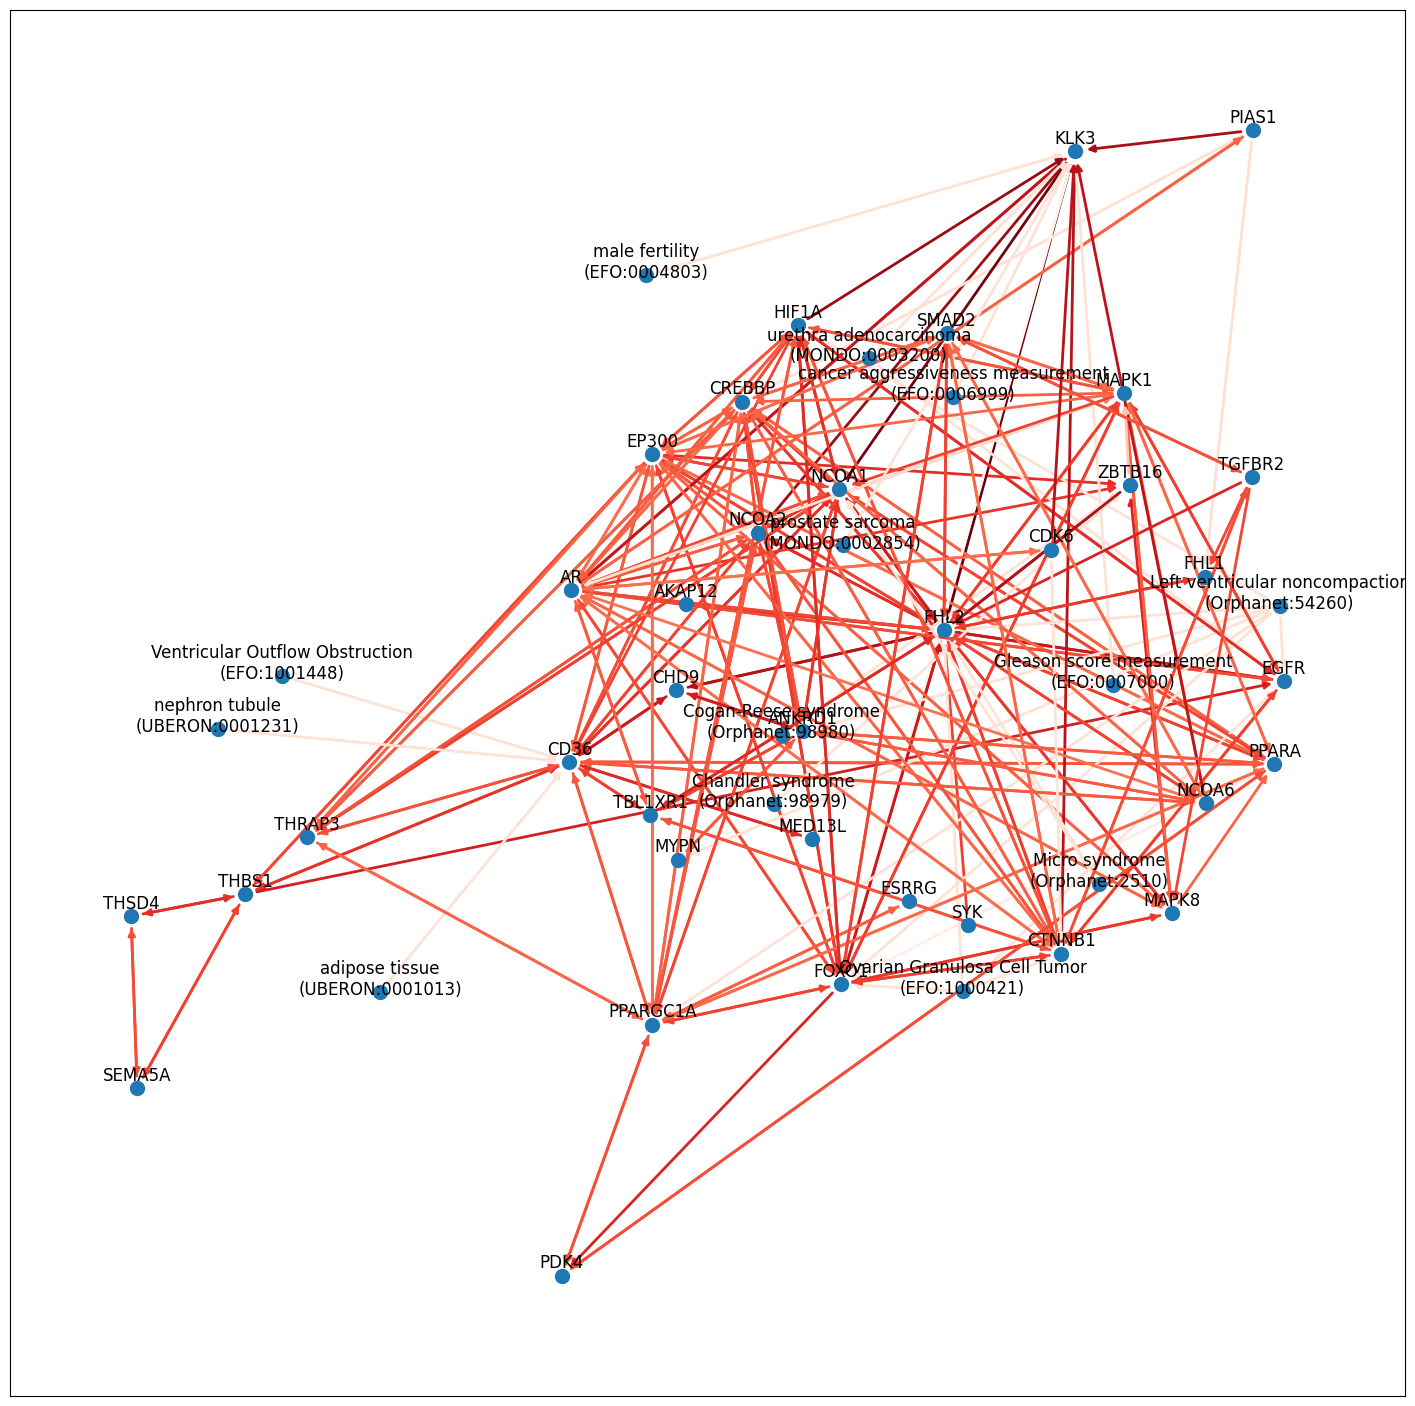

In [91]:
matplotlib.rcParams['figure.figsize'] = [18, 18]

_=plot_graph(exprKGs["Fibroblast"].kg.subgraph(rev_partition[4]), pos=pos)

In [79]:
import pickle

with open("exprkgs.pickle", 'wb') as f:
    pickle.dump(exprKGs, f)

0 540
1 274
2 40
3 49
4 143
5 70
6 108
7 128
8 236
9 160
11 37
12 181
37 61
16 38
18 30
19 33
14 25
22 23

Adipocyte 2.0022692033298926
Cardiomyocyte 1.9112754878459841
Cycling cells 3.501892191936319
Endothelial 3.749195438480572
Fibroblast 3.218029903565794
Lymphoid 4.175526038890934
Mast 3.292164150872761
Myeloid 3.5449779077305705
Neuronal 3.5358279200585057
Pericyte 3.6713458122682305
vSMCs 3.001252547383736


/usr/local/hdd3/mikg/scripts/../mikg/kgraph.py:383: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


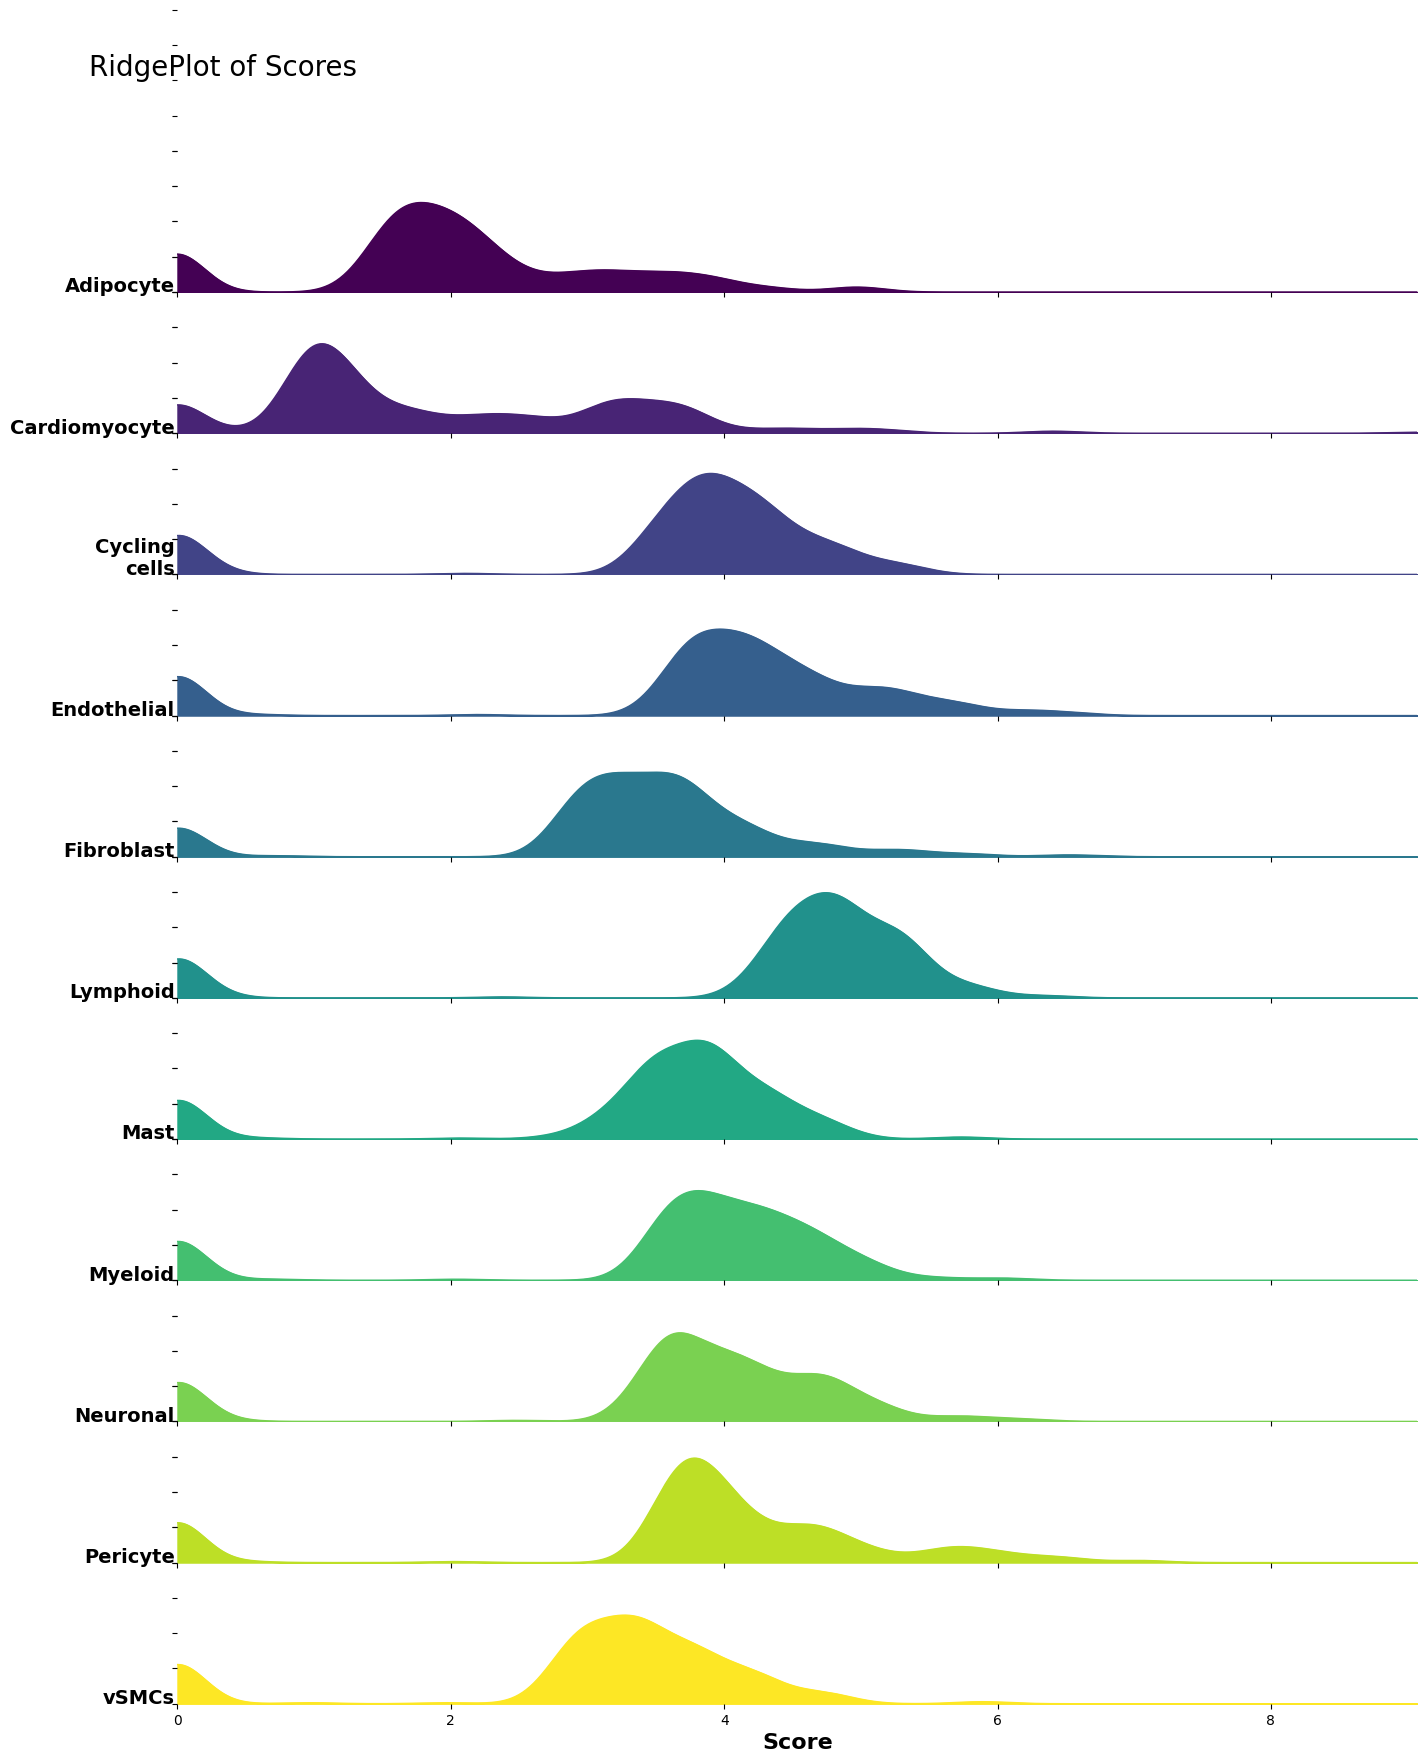

In [92]:
kgScores =kg.score_subgraphs_for_subnet(exprKGs, rev_partition[4])
kg.plot_subgraph_scores(kgScores)

Adipocyte 0.7972619676003612
Cardiomyocyte 1.1531370839132018
Cycling cells 1.7167586183611592
Endothelial 1.8049339822293404
Fibroblast 1.5650736981664881
Lymphoid 2.0243807591890746
Mast 1.5414483287343483
Myeloid 1.6566944861607418
Neuronal 2.0674232067945395
Pericyte 1.8087303375069947
vSMCs 1.5238895268310937


/usr/local/hdd3/mikg/scripts/../mikg/kgraph.py:383: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


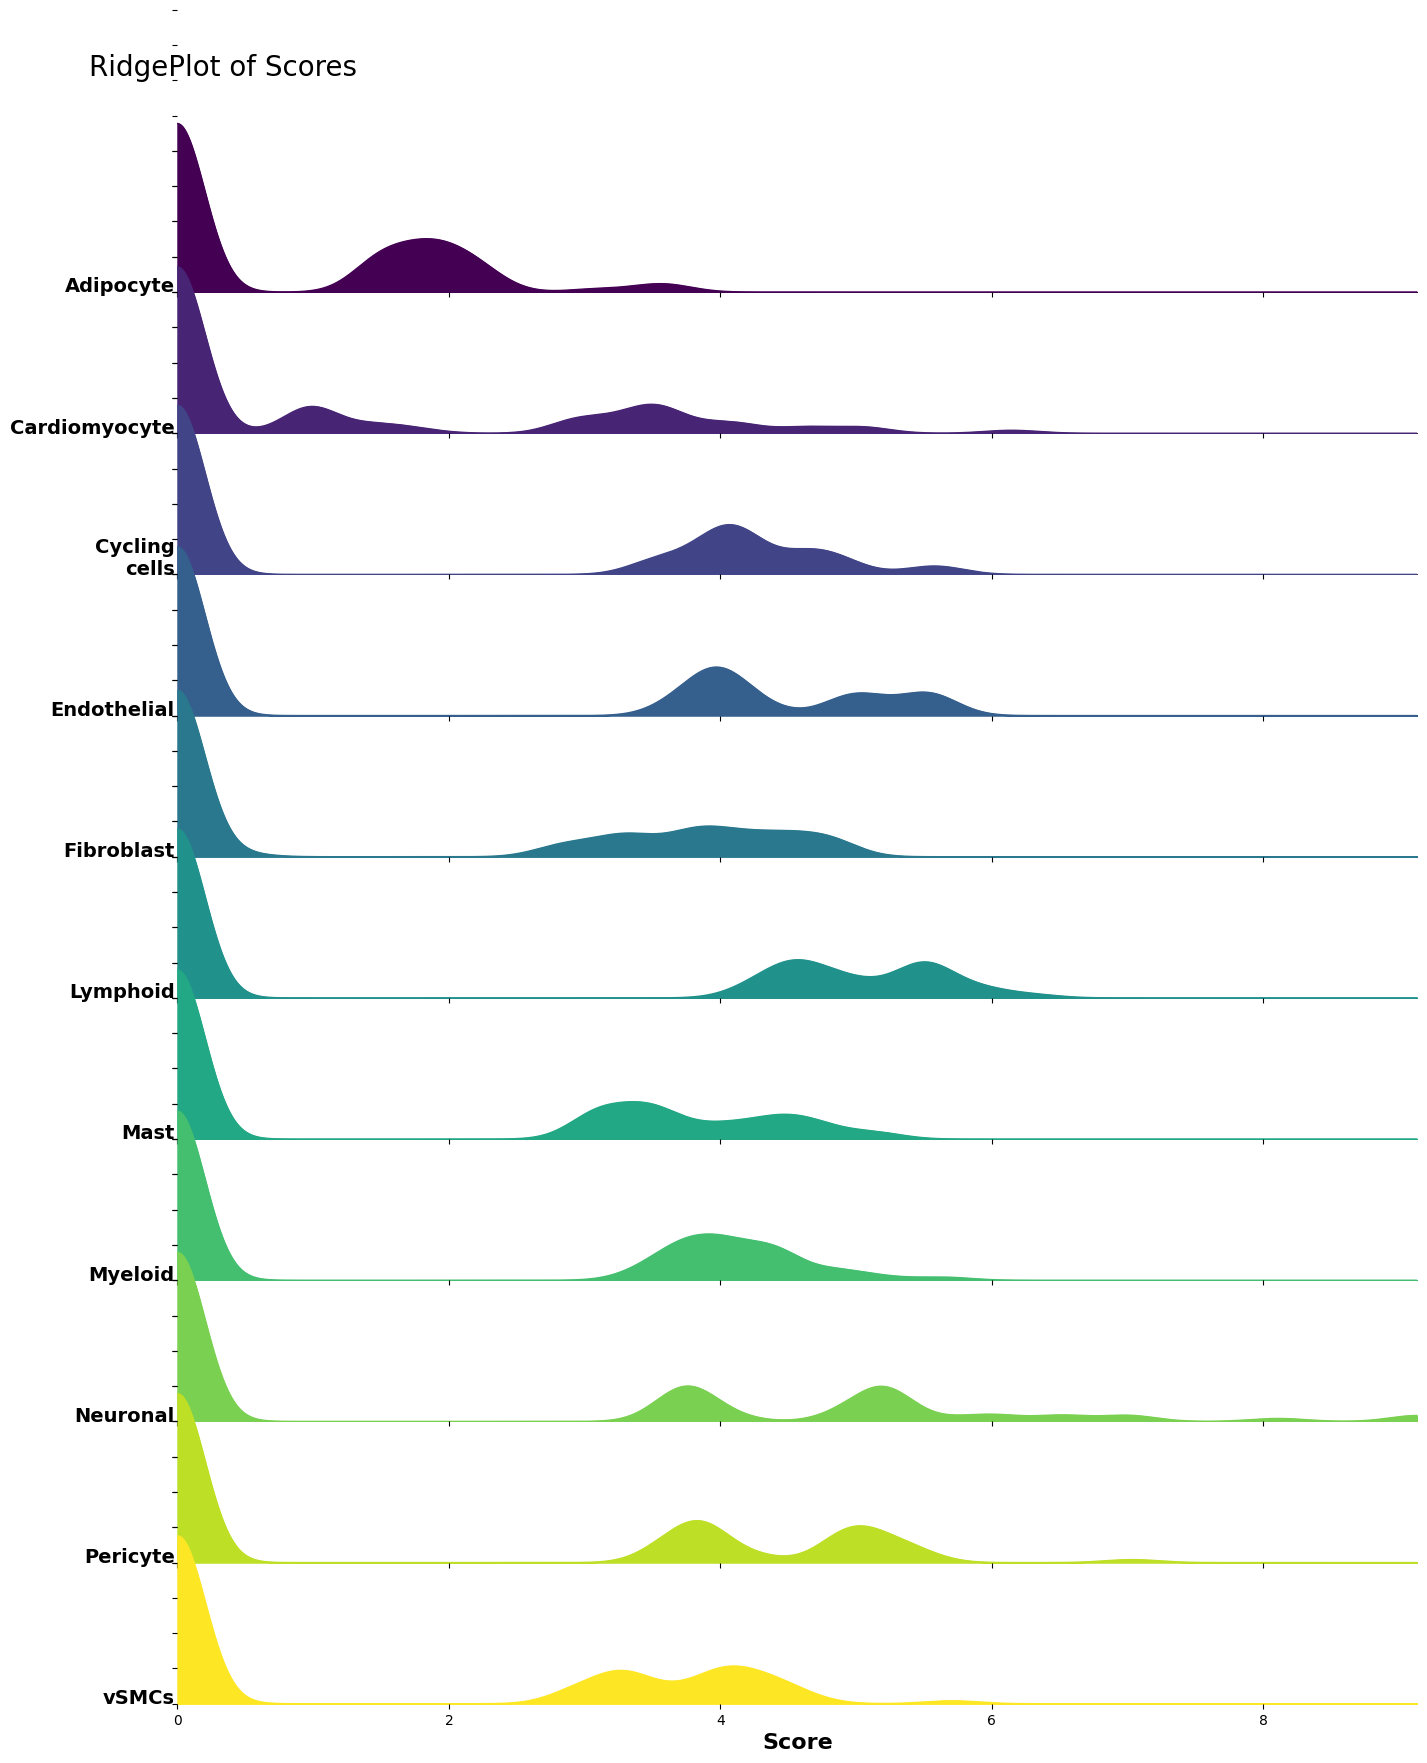